# Fluorescence lifetime microscopy (FLIM)

Time correlated single photon counting (TCSPC) detects single photons of a periodic light signal and determines the times of the photons after the excitation pulses.

<div>
<img src="./static/images/FLIM/flimprinciple.png" width="650"/>
</div>

## FLIM theory
### Fitting a model to the decay curve approach

A fluorophore decays with time according to the relation:

$$
I_{(t)} = A_0e^{-t/\tau_0}
$$

where $\tau_0$ is the fluorescence lifetime and $A_0$ is the amplitude.

To model more complex kinetics of fluorophores, the decay is usually model by a sum of exponentials:

$$
I_{(t)} = \sum_{i=1}^n A_ie^{-t/\tau_i}
$$

where $\tau_0$ is the fluorescence lifetime and $A_0$ is the amplitude.

The model fit can be done in specialized SW or by scripting.

<div>
<img src="./static/images/FLIM/flim_fit.png" width="650"/>
</div>

### Phasor plot: the model-free approach

Representation of the fluorescence lifetime using the phasor plot model-free aproach. The phasor is a graphical representation of the transformed raw data.

The single decay component fluorophore sits on the universal circle and the position on the circle reflects the lifetime $\tau_0$ in respect with the laser repetition rate $\omega$.

The two phasors $g$ and $s$ are obtained through the transformation as:

$$
g_{(x,y)}(\omega) = \frac{\int I_{x,y}(t)\cos(\omega t)\,dt\,}{\int I_{x,y}(t)\,dt\,}
$$

$$
s_{(x,y)}(\omega) = \frac{\int I_{x,y}(t)\sin(\omega t)\,dt\,}{\int I_{x,y}(t)\,dt\,}
$$

The graphic represantation of the phasor is the universal semicircle with a point cloud of transformed decayes.

<div>
<img src="./static/images/FLIM/phasor_single.png" alt="Drawing" style="width: 450px;"/>
</div>

The complex micture of fluorescence specimen will be represented as a linear combination of those specimen in the universal semicircle.

<div>
<img src="./static/images/FLIM/multiple_components.jpg" width="450"/>
</div>

## Code blocks for FLIM data phasor analysis

The B&H FLIM data can be analysed in Python using multiple libraries such as numpy, sdtfile and others.

For example, here's some sample code to read the sdtfiles, transform them to phasor plot and compare measurments:

In [1]:
# Import necessary packeges
import numpy as np
from sdtfile import SdtFile
import matplotlib.pyplot as plt


c:\Users\daniel.hadraba\AppData\Local\anaconda3\python.exe


In [2]:
# Select the sdt file
file_path = "./static/sdt/calibration/rhodamineB_in-methanol_ex805_1024x1024_px180_em610_05AOM_05_internal_001.sdt"
# Load the sdt file and print the number of channels
flim_file = SdtFile(file_path)
print("The number of channels is: ", len(flim_file.data))
# Load the data from first channel
data = flim_file.data[0]
print("The shape of the data is (x, y, time bins): ", data.shape)


The number of channels is:  1
The shape of the data is (x, y, time bins):  (1024, 1024, 256)


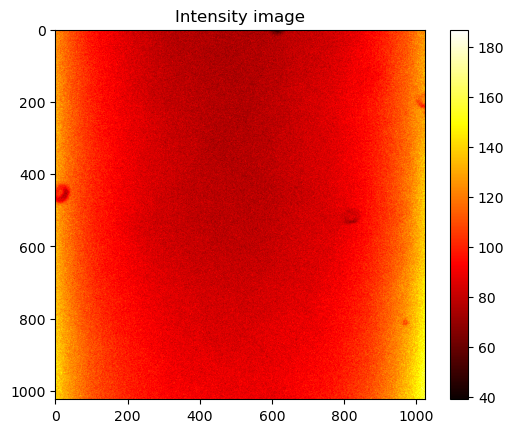

In [3]:
# Create an intensity image of the FLIM data and plot it
intensity_image = np.sum(data, axis=2)
# Plot the intensity image
plt.imshow(intensity_image, cmap='hot')
# Add colorbar
plt.colorbar()
# Add title
plt.title("Intensity image")
plt.show()

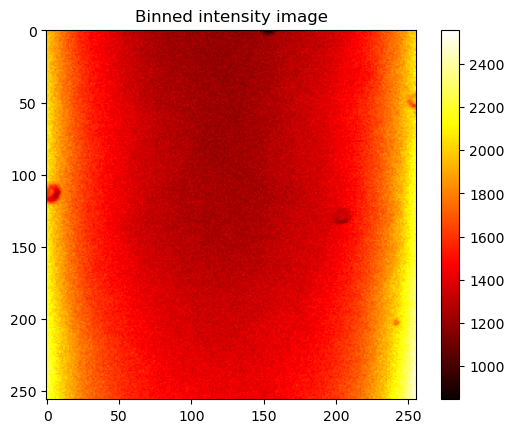

In [4]:
# Bin the data in x, y to increase the photon count
# Bin factor
bin_factor = 4
# Bin the data according to the bin factor
binned_image = intensity_image.reshape((intensity_image.shape[0] // bin_factor, bin_factor,
                                  intensity_image.shape[1] // bin_factor, bin_factor)).sum(axis=(1, 3))
# Plot the binned image
plt.imshow(binned_image, cmap='hot')
plt.colorbar()
plt.title("Binned intensity image")
plt.show()

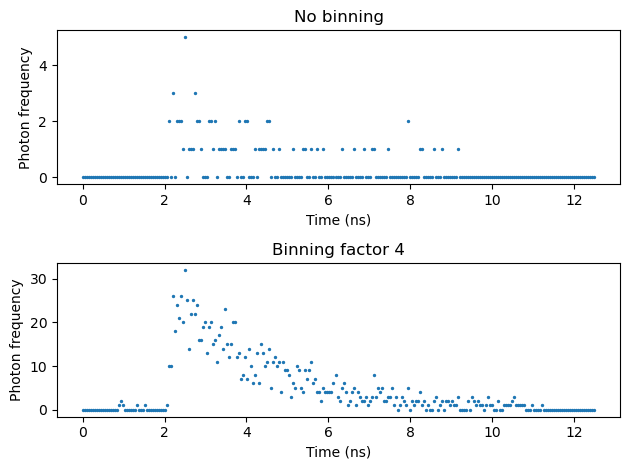

In [5]:
# Plot the flourescence lifetime decay for a pixel and binned data
# Create a time array for the x-axis
time = np.linspace(0, 12.5, data.shape[2])
# Binned data according to the bin factor and keep the third dimension
data_binned = data.reshape((data.shape[0] // bin_factor, bin_factor,
                            data.shape[1] // bin_factor, bin_factor,
                            data.shape[2])).sum(axis=(1, 3))
# Select a pixel from the data with all the time bins
data_pixel = data[512, 512, :]
# Select a pixel from the binned data
data_binned_pixel = data_binned[512 // bin_factor, 512 // bin_factor, :]
# Plot the results
fig, ax = plt.subplots(2, 1)
ax[0].scatter(time, data_pixel, s = 2)
ax[0].set_title("No binning")
ax[0].set_xlabel("Time (ns)"), ax[0].set_ylabel("Photon frequency")
ax[1].scatter(time, data_binned_pixel, s = 2)
# ax[1].set_yscale("log")
ax[1].set_title("Binning factor " + str(bin_factor))
ax[1].set_xlabel("Time (ns)"), ax[1].set_ylabel("Photon frequency")
fig.tight_layout() 

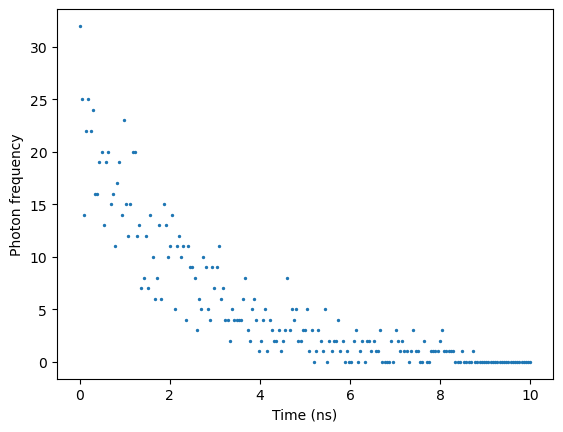

In [6]:
# Find the index of the maximum value in decay data
max_index = np.argmax(data_binned_pixel)

# Slice the vector to keep only the values on the right side behind the peak
sliced_data = data_binned_pixel[max_index:]
sliced_time = time[max_index:]
sliced_time = sliced_time - sliced_time[0]

# Plot the sliced data
plt.scatter(sliced_time, sliced_data, s = 2)
plt.xlabel("Time (ns)"), plt.ylabel("Photon frequency")
plt.show()

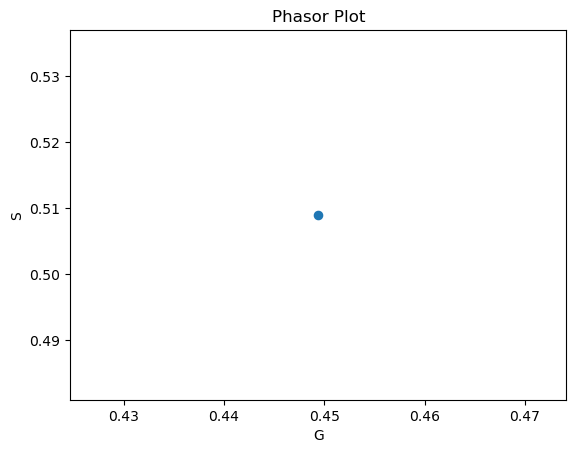

In [7]:
# Laser frequency input
f_laser = 80e6
omega = 2 * np.pi * f_laser

# Time vector
t = sliced_time*1e-9

# Calculate the phasor coordinates
g = np.sum(sliced_data * np.cos(omega * t)) / np.sum(sliced_data)
s = np.sum(sliced_data * np.sin(omega * t)) / np.sum(sliced_data)

# Plot the phasor plot
fig, ax = plt.subplots(1,1)
ax.scatter(g, s, s=35)
ax.set_xlabel('G')
ax.set_ylabel('S')
ax.set_title('Phasor Plot')
plt.show()

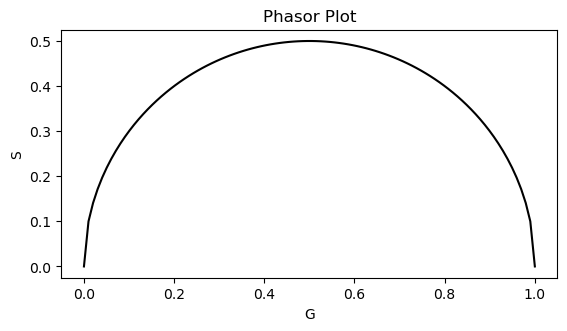

In [8]:
# Plot the universal circle 
center_x = 0.5
center_y = 0
radius = 0.5
x_corr = np.linspace(-radius + center_x, radius + center_x, 100)
y_corr = radius * np.sqrt(1 - ((x_corr - center_x) / radius) ** 2) + center_y
fig, ax = plt.subplots(1,1)
ax.plot(x_corr, y_corr, 'k')
ax.set_xlabel('G')
ax.set_ylabel('S')
ax.set_title('Phasor Plot')
ax.axes.set_aspect('equal')

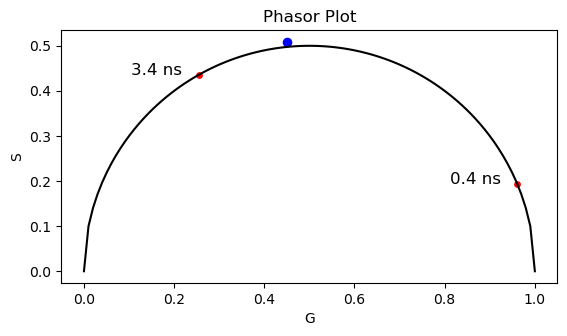

In [9]:
# Add the bound (3.4 ns) and free (0.4) NADH points to the phasor plot
tau = [3.4, 0.4]
g_NADH = []
s_NADH = []
# Calculate the phasor coordinates for the NADH points
for tau_m in tau: 
    s_now = (2*np.pi*f_laser*tau_m*1e-9)/(1 + (2*np.pi*f_laser)**2*((tau_m*1e-9)**2))
    g_now = 1/(1 + (2*np.pi*f_laser)**2*((tau_m*1e-9)**2))
    g_NADH.append(g_now)
    s_NADH.append(s_now)
NADH = np.vstack((g_NADH, s_NADH))
# Plot the phasor plot with the NADH points
fig, ax = plt.subplots(1,1)
ax.scatter(g, s, s = 35, c='b')
ax.plot(x_corr, y_corr, 'k')
ax.scatter(g_NADH, s_NADH, s=15, c='r')
ax.set_xlabel('G')
ax.set_ylabel('S')
ax.set_title('Phasor Plot')
# Plot text in x, y coordinates
ax.text(g_NADH[0]-0.15, s_NADH[0], '3.4 ns', color='k', fontsize=12)
ax.text(g_NADH[1]-0.15, s_NADH[1], '0.4 ns', color='k', fontsize=12)
ax.axes.set_aspect('equal') 

There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)